In [237]:
# import
import jax.numpy as jnp
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft, fftfreq
import numpy as np

In [238]:
# Get Data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
Y_train = pd.read_csv('../data/Y_train.csv')

In [239]:
X_train

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11
10601,2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66
10602,2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01
10603,2023-03-29 22:00:00+02:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74


In [240]:
from sklearn.impute import KNNImputer

print(X_train.shape, X_test.shape)

def featureIngeneering(X):
    hours = np.array([(int(X["DELIVERY_START"].iloc[i][11:13]) + 1 ) % 24 for i in range(len(X["DELIVERY_START"]))])
    months = np.array([int(X["DELIVERY_START"].iloc[i][5:7]) for i in range(len(X["DELIVERY_START"]))])
    days = np.array([int(X["DELIVERY_START"].iloc[i][8:10]) for i in range(len(X["DELIVERY_START"]))])
    years = np.array([int(X["DELIVERY_START"].iloc[i][0:4]) for i in range(len(X["DELIVERY_START"]))])
    X = X.drop(columns=["DELIVERY_START"])

    days_sin = np.sin(2 * np.pi * days / 31)
    days_cos = np.cos(2 * np.pi * days / 31)
    hours_sin = np.sin(2 * np.pi * hours / 24)
    hours_cos= np.cos(2 * np.pi * hours / 24)
    months_sin = np.sin(2 * np.pi * months / 12)
    months_cos = np.cos(2 * np.pi * months / 12)

    years = (years - 2022.5)*2

    X["years"] = years
    X["days_sin"] = days_sin
    X["days_cos"] = days_cos
    X["hours_sin"] = hours_sin
    X["hours_cos"] = hours_cos
    X["months_sin"] = months_sin
    X["months_cos"] = months_cos

    return X

delivery_start = X_test['DELIVERY_START']

X_train = featureIngeneering(X_train)
X_test = featureIngeneering(X_test)

# Concatenate X_train and X_test to impute missing values
# We need to separete them afterwards
# X_train end at 2023-03-29 23:00:00 and X_test start at 2023-04-02 00:00:00,
# so i need to fill that ranges with a dataframe with hours, months and na values for the rest of the columns

between = pd.DataFrame(columns=X_train.columns)

for j in range(24):
    between = between.append({'DELIVERY_START': f'2023-03-30 {j:02d}:00:00+01:00'}, ignore_index=True)
    between = between.append({'DELIVERY_START': f'2023-03-31 {j:02d}:00:00+01:00'}, ignore_index=True)
    between = between.append({'DELIVERY_START': f'2023-04-01 {j:02d}:00:00+01:00'}, ignore_index=True)

between = featureIngeneering(between)

End_train = len(X_train)
Begin_test = len(X_train) + len(between)

X = pd.concat([X_train, between, X_test])
# I want to normalize the data except for column with cycle encoding
column = X.columns
column = column.drop(['years', 'days_sin', 'days_cos', 'hours_sin', 'hours_cos', 'months_sin', 'months_cos'])
X[column] = (X[column] - X[column].mean()) / X[column].std()

imputer = KNNImputer(n_neighbors=5)
imputer.fit_transform(X)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


X_train, X_test = X[:End_train], X[Begin_test:]

print(X_train.shape, X_test.shape)

(10605, 10) (4942, 10)


/var/folders/k7/5bqh6vbs2jg9btyl5pw1cyqr0000gn/T/ipykernel_23385/1530167509.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  between = between.append({'DELIVERY_START': f'2023-03-30 {j:02d}:00:00+01:00'}, ignore_index=True)
/var/folders/k7/5bqh6vbs2jg9btyl5pw1cyqr0000gn/T/ipykernel_23385/1530167509.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  between = between.append({'DELIVERY_START': f'2023-03-31 {j:02d}:00:00+01:00'}, ignore_index=True)
/var/folders/k7/5bqh6vbs2jg9btyl5pw1cyqr0000gn/T/ipykernel_23385/1530167509.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  between = between.append({'DELIVERY_START': f'2023-04-01 {j:02d}:00:00+01:00'}, ignore_index=True)
/var/folders/k7/5bqh6vbs2jg9btyl5pw1cyqr0000gn/T/

(10605, 16) (4942, 16)


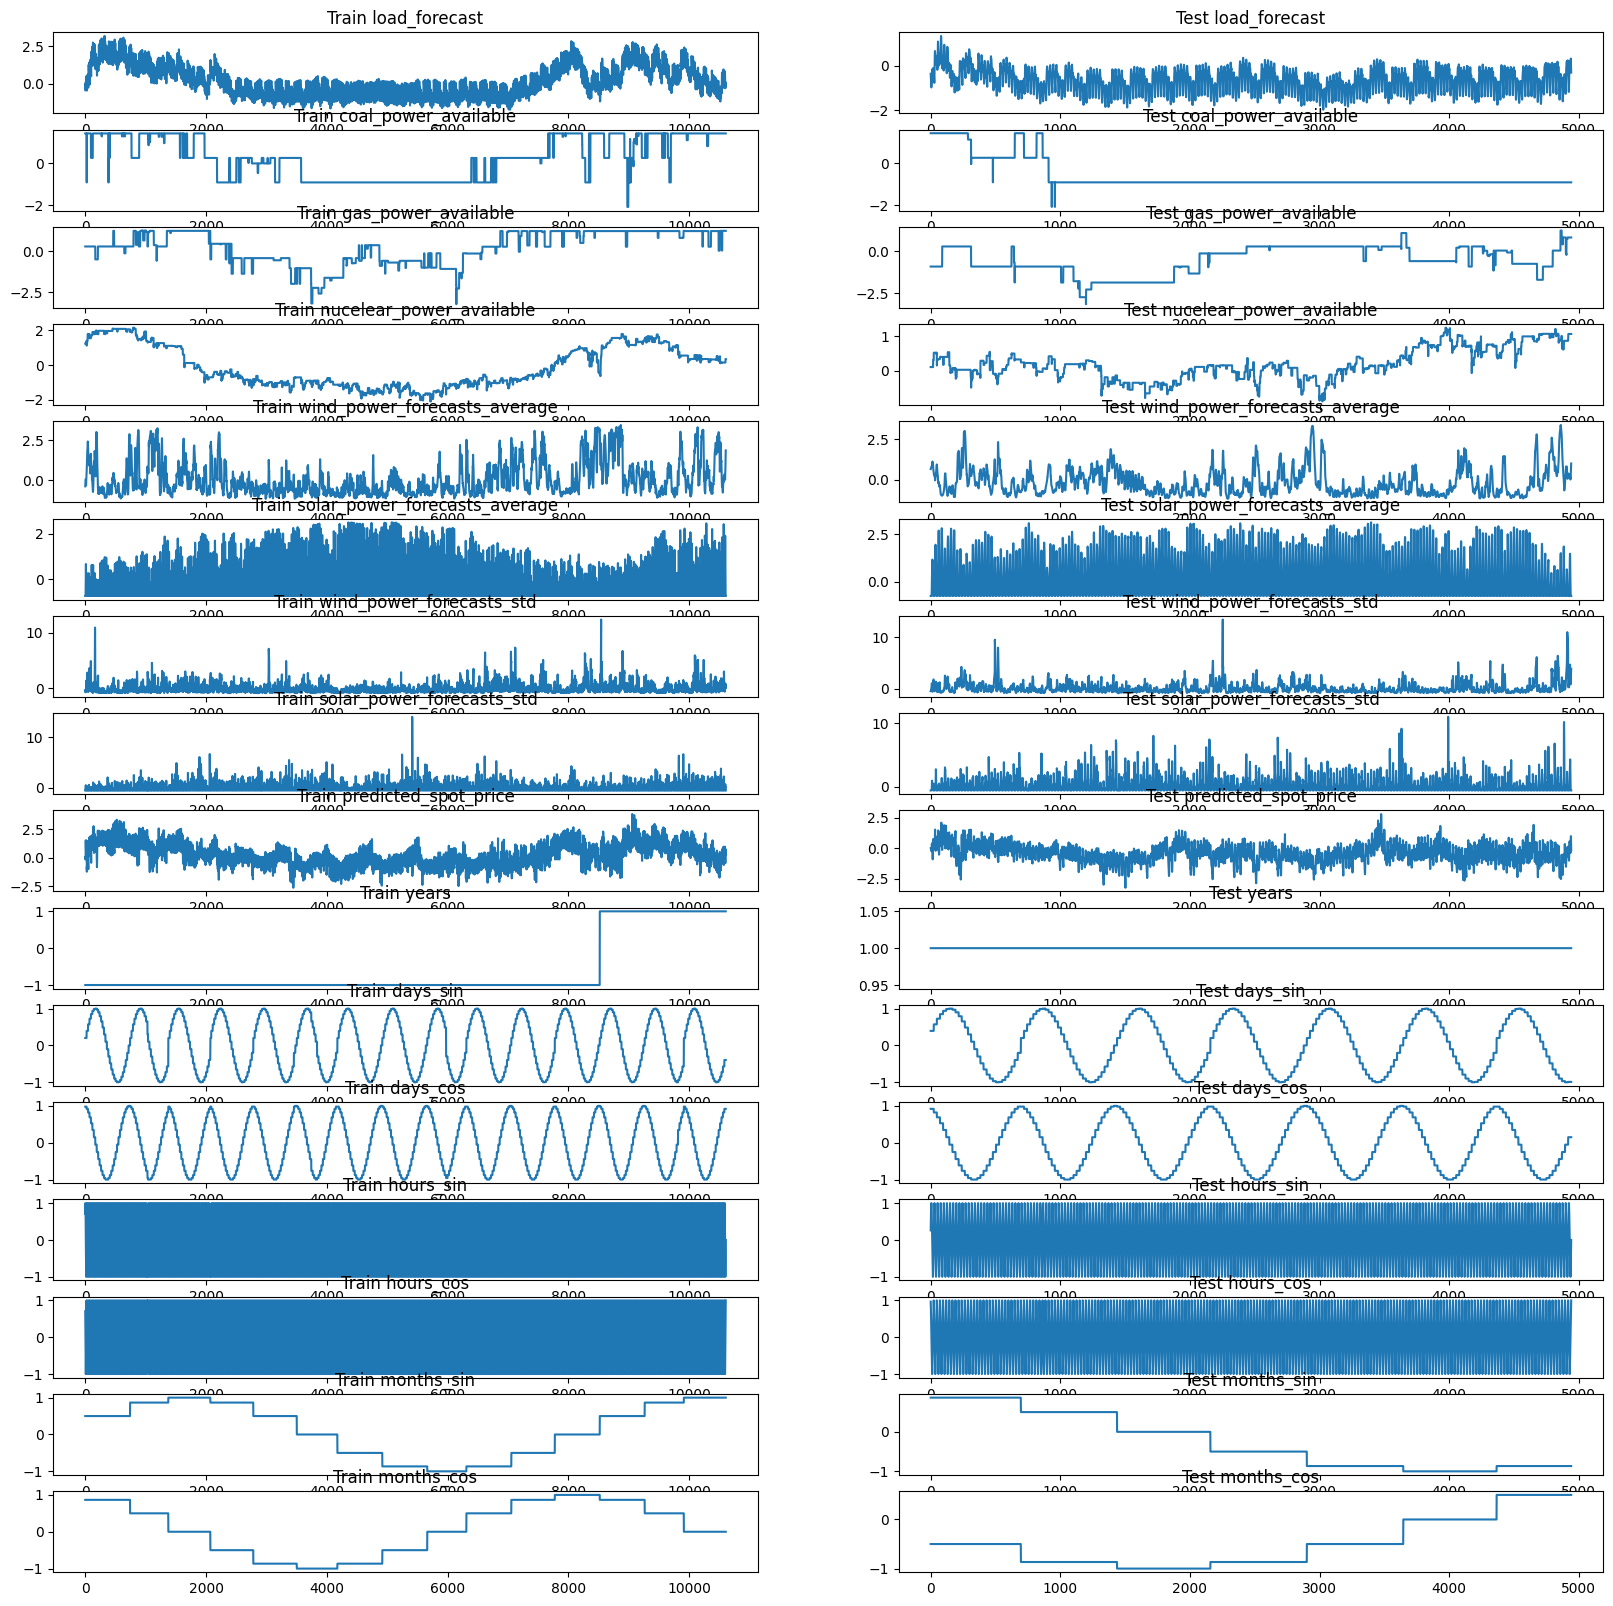

In [241]:
# Let's visualize all the data
train_columns = X_train.columns
test_columns = X_test.columns

# Create a figure with subplots
fig, axs = plt.subplots(len(train_columns), 2, figsize=(20, 20))

# Loop over the columns
for i, column in enumerate(train_columns):
    # Plot the train data
    axs[i, 0].plot(np.array(X_train[column]))
    axs[i, 0].set_title(f'Train {column}')
    # Plot the test data
    axs[i, 1].plot(np.array(X_test[column]))
    axs[i, 1].set_title(f'Test {column}')

# Show the plot
plt.show()


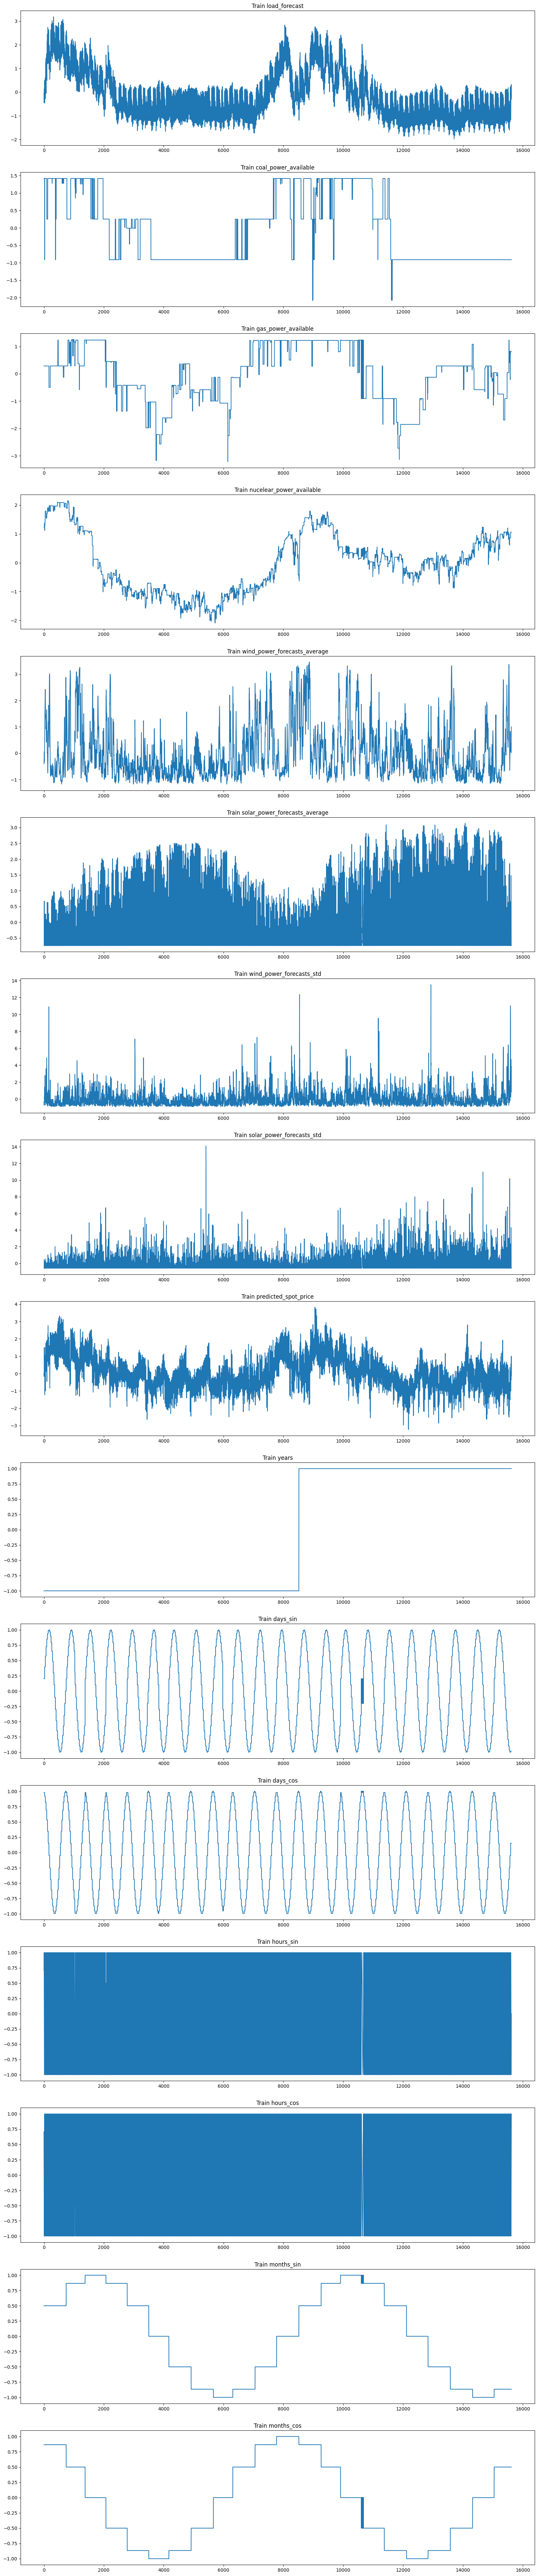

In [242]:
# Assuming X is defined and contains the data to plot
x_columns = X.columns

# Create a figure with subplots
fig, axs = plt.subplots(len(x_columns), 1, figsize=(20, 100)) # Adjusted to ensure axs is 2D if needed

# Loop over the columns
for i, column in enumerate(x_columns):
    if len(x_columns) > 1: # If more than one subplot, axs is a 1D numpy array.
        ax = axs[i]
    else: # If only one subplot, axs is a scalar.
        ax = axs
    ax.plot(np.array(X[column]))
    ax.set_title(f'Train {column}')

# Show the plot
plt.show()


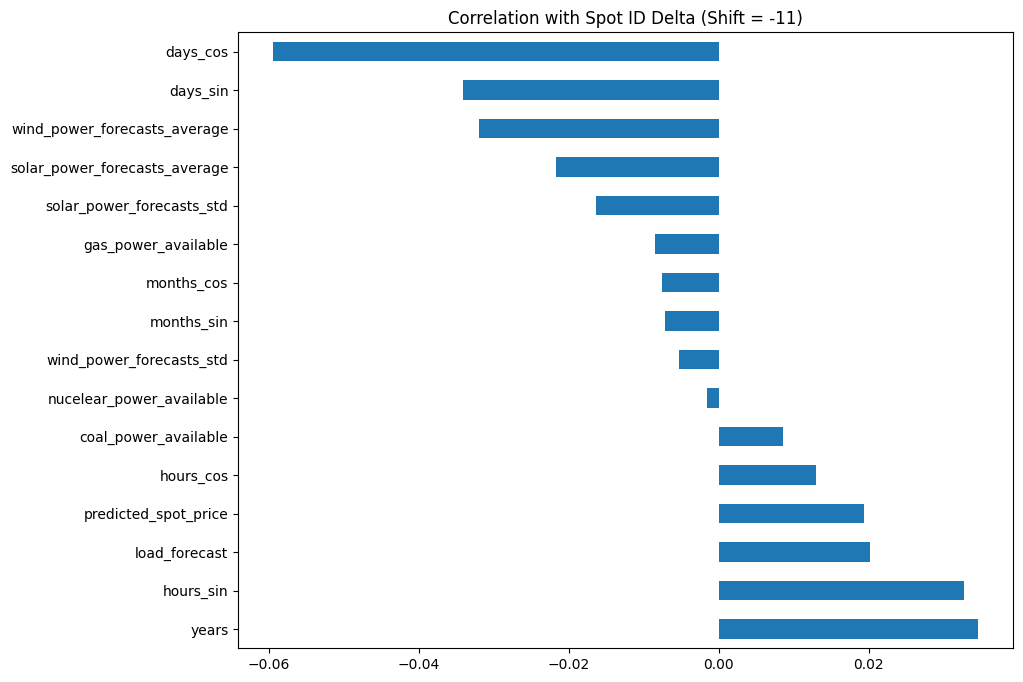

In [243]:
%matplotlib inline
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 8))

def update(shift):
    ax.clear()
    # Compute the shifted correlation
    correlation = X_train.shift(shift).corrwith(Y_train['spot_id_delta'])
    correlation = correlation.sort_values(ascending=False)
    correlation.dropna(inplace=True)  # Drop NaN values which might result from the shift
    # Plotting
    correlation.plot(kind='barh', ax=ax)
    ax.set_title(f'Correlation with Spot ID Delta (Shift = {shift})')

# Create an animation with shifts from -5 to 5, inclusive
ani = FuncAnimation(fig, update, frames=range(-11, 12), repeat=True)

# Convert the animation to HTML and display it within the notebook
HTML(ani.to_jshtml())


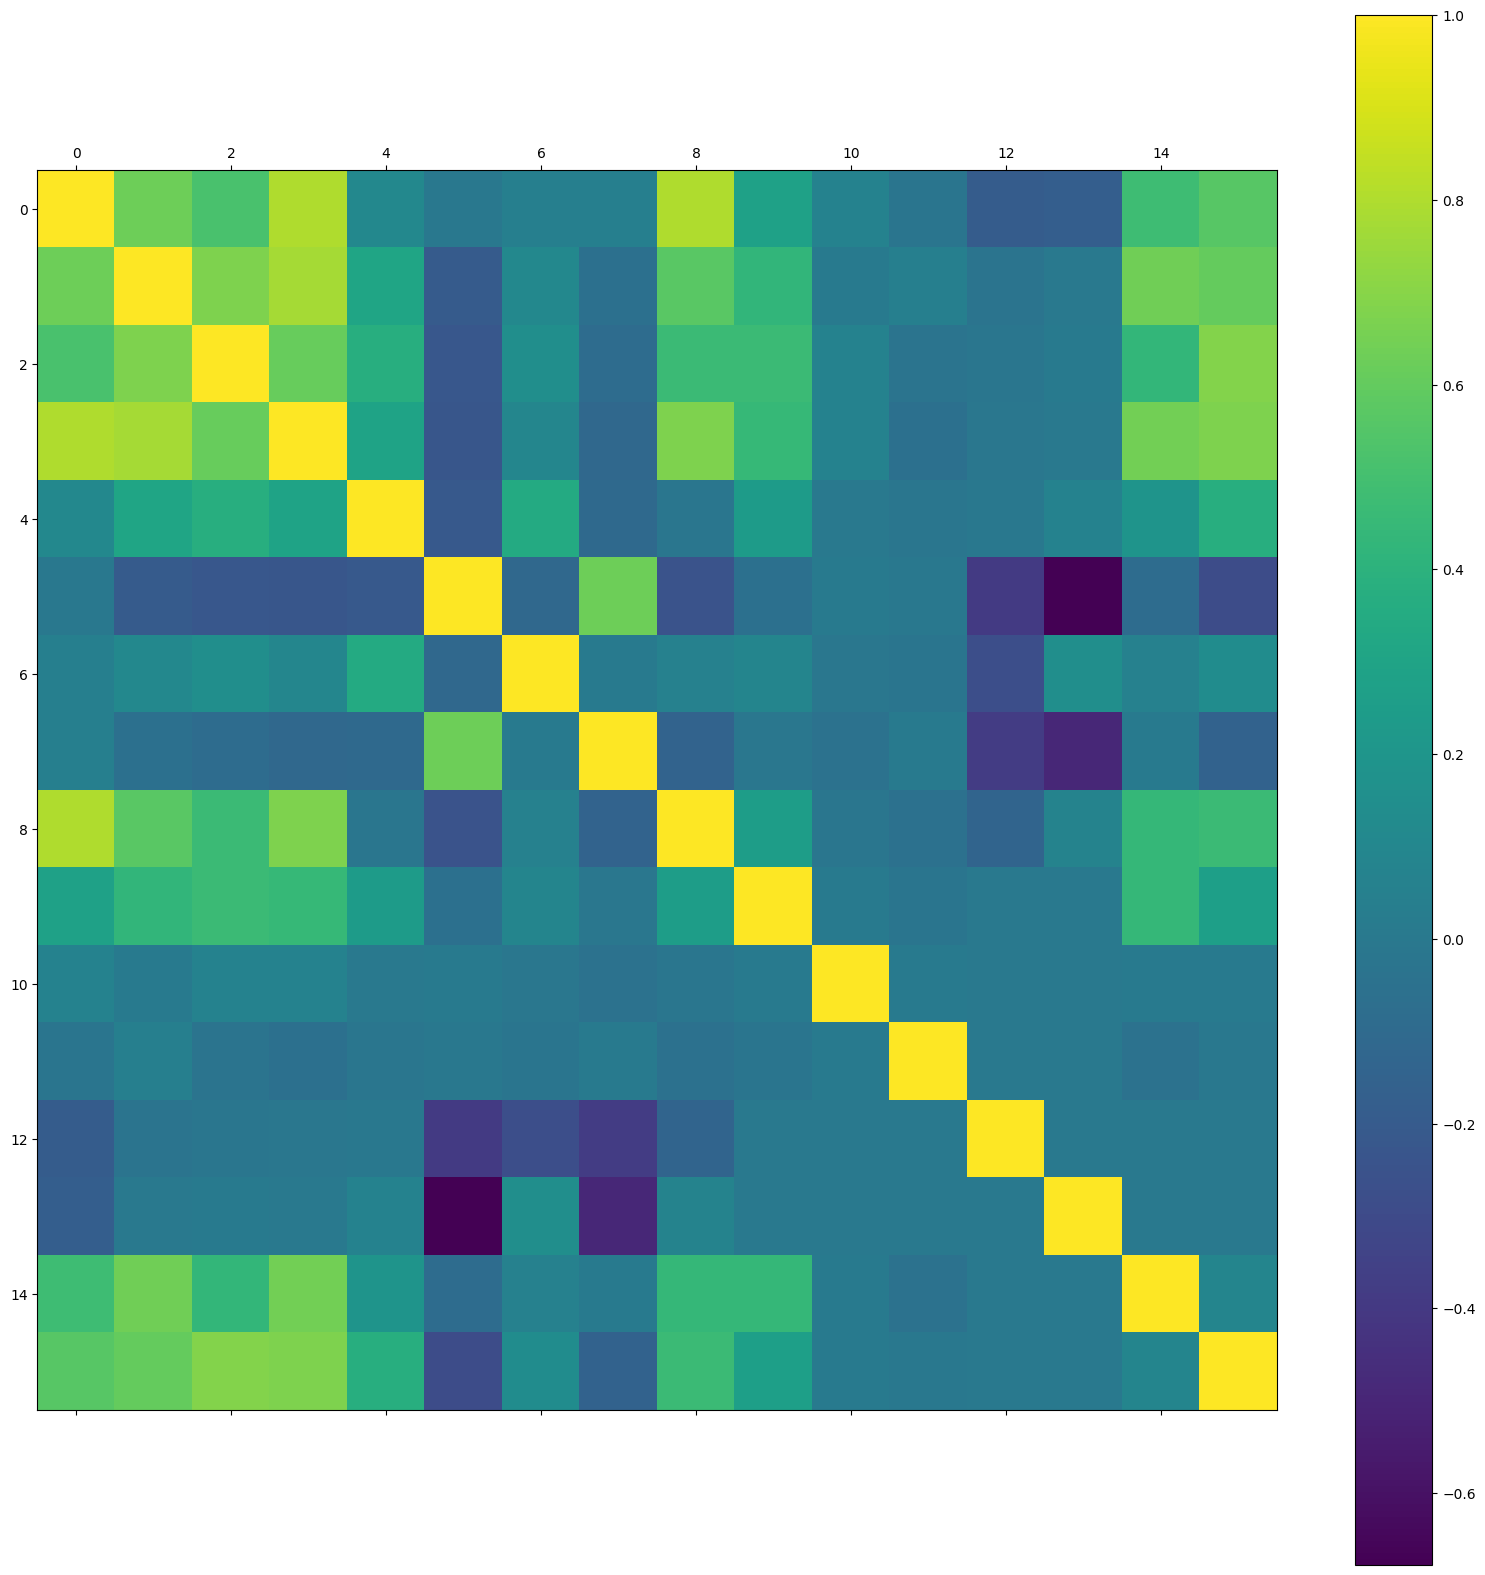

In [244]:
# Correlation between features
correlation_matrix = X_train.corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation_matrix, fignum=1)
plt.colorbar()

In [245]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        # Adjust for odd d_model: compute cosine for up to the second last if d_model is odd
        pe[:, 1::2] = torch.cos(position * div_term)[:,:d_model//2]
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[ : x.size(1), 0, :] 
'''
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, output_dim, window_size, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.pos_encoder = PositionalEncoding(model_dim, window_size)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.dense_layer = nn.Linear(model_dim, model_dim)  # Additional dense layer
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(model_dim, output_dim)  # Adjusted for potential multiple outputs
        self.relu = nn.ReLU()
        
        # For a single output per sequence, ensure output_dim is 1 and adjust forward accordingly
        self.output_dim = output_dim
        self.window_size = window_size

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        encoded = self.transformer_encoder(src)
        encoded = self.relu(self.dense_layer(encoded))
        output = self.output_layer(encoded)
        output = output.mean(dim=1)  # Ensure this step matches your output requirements
        output = torch.sigmoid(output)
        
        return output
'''

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, output_dim, window_size, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.embedding_dropout = nn.Dropout(dropout)  # Dropout after embedding
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.pos_encoder = PositionalEncoding(model_dim, window_size)  # Ensure dropout is correctly applied in your positional encoding if necessary
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.dense_layer = nn.Linear(model_dim, model_dim)
        self.output_dropout = nn.Dropout(dropout)  # Additional dropout before the output layer
        self.output_layer = nn.Linear(model_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, src):
        src = self.embedding(src)
        src = self.embedding_dropout(src)  # Apply dropout after embedding
        src = self.pos_encoder(src)
        encoded = self.transformer_encoder(src)
        encoded = self.relu(self.dense_layer(encoded))
        encoded = self.output_dropout(encoded)  # Apply dropout before the output layer
        output = self.output_layer(encoded)
        output = output.mean(dim=1)  # Ensure this step matches your output requirements
        output = torch.sigmoid(output)
        
        return output

    
def padding(data, input_window):
    # Assuming padding adds necessary elements to make the data compatible with window size
    # Update this function if necessary to efficiently pad your data
    return torch.nn.functional.pad(data, (0, 0, input_window//2, input_window//2), "constant", 0)

def get_data(x, y, input_window, device):
    """Optimized version of splitting data into sequences of equal length."""

    # Efficiently pad the data
    x = padding(x, input_window)
    y = padding(y, input_window)
    
    # Utilize tensor operations to create sequences without explicit loops
    x_seq = torch.stack([x[i:i+input_window] for i in range(len(x) - input_window + 1)]).to(device)
    y_seq = torch.stack([y[i+input_window//2] for i in range(len(y) - input_window + 1)]).to(device)

    return x_seq, y_seq

def train(train_loader, model, criterion, optimizer, scheduler, epoch, device):
    model.train()  # Set model to training mode
    total_loss = 0
    start_time = time.time()

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # Clip gradient norm
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:  # Adjust print frequency as needed
            elapsed = time.time() - start_time
            print('| Epoch: {:3d} | Batch: {:5d} | Loss: {:.6f} | Time: {:.2f}s'.format(
                epoch, batch_idx, total_loss / (batch_idx + 1), elapsed))
            start_time = time.time()  # Resetting start time
        
        scheduler.step()  # Update learning rate after each batch
    print(f'LR: {scheduler.get_last_lr()}')
    # Update the learning rate after each epoch

    return total_loss / len(train_loader)

def custom_loss(output, target):
    weight = torch.abs(target)
    target = (torch.sign(target) > 0).float()
    bce = (target*torch.log(output+1e-9) + (1-target)*torch.log(1-output+1e-9))
    return torch.mean(bce*weight*-1)

def evaluate(test_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_weighted_accuracy = 0.0
    total_weight = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            y_pred = output
            y_test = targets
            y_pred = torch.sign(y_pred - 0.5)
            correct_predictions_proportion = (torch.sign(y_pred*y_test)>0).float()
            weights = torch.abs(y_test)
            total_weighted_accuracy += torch.sum(correct_predictions_proportion * weights)
            total_weight += torch.sum(weights)
    
    score = total_weighted_accuracy / total_weight
    score = score.cpu().numpy()
    print(f'Weighted Accuracy: {score:.2f}')
    return score


In [246]:
Y_train = Y_train['spot_id_delta']

N = 5
window_size = 2*N+1

device = torch.device("mps")

# Convert numpy arrays to PyTorch tensors and ensure they are of dtype float32
x = torch.from_numpy(np.array(X_train)).float()
y = torch.from_numpy(np.array(Y_train)).float().view(-1, 1)

x_seq, y_seq= get_data(x, y, input_window=window_size, device=device)

# Slit the data into train and test
x_train_seq, x_test_seq, y_train_seq, y_test_seq = train_test_split(x_seq, y_seq, test_size=0.2, random_state=42)

| Epoch:   1 | Batch:     0 | Loss: 13.616228 | Time: 0.16s
| Epoch:   1 | Batch:    10 | Loss: 12.371567 | Time: 0.37s
| Epoch:   1 | Batch:    20 | Loss: 12.652426 | Time: 0.37s
| Epoch:   1 | Batch:    30 | Loss: 13.080709 | Time: 0.38s
| Epoch:   1 | Batch:    40 | Loss: 13.304450 | Time: 0.37s
| Epoch:   1 | Batch:    50 | Loss: 13.589943 | Time: 0.36s
| Epoch:   1 | Batch:    60 | Loss: 13.585216 | Time: 0.36s
| Epoch:   1 | Batch:    70 | Loss: 13.553782 | Time: 0.40s
| Epoch:   1 | Batch:    80 | Loss: 13.659037 | Time: 0.37s
| Epoch:   1 | Batch:    90 | Loss: 13.445275 | Time: 0.43s
| Epoch:   1 | Batch:   100 | Loss: 13.443882 | Time: 0.40s
| Epoch:   1 | Batch:   110 | Loss: 13.416372 | Time: 0.39s
| Epoch:   1 | Batch:   120 | Loss: 13.599339 | Time: 0.37s
| Epoch:   1 | Batch:   130 | Loss: 13.592861 | Time: 0.36s
LR: [5.034399627683477e-06]
--------------------------------------------------------------------------------
| end of epoch   1 | time:  5.17s
-----------------

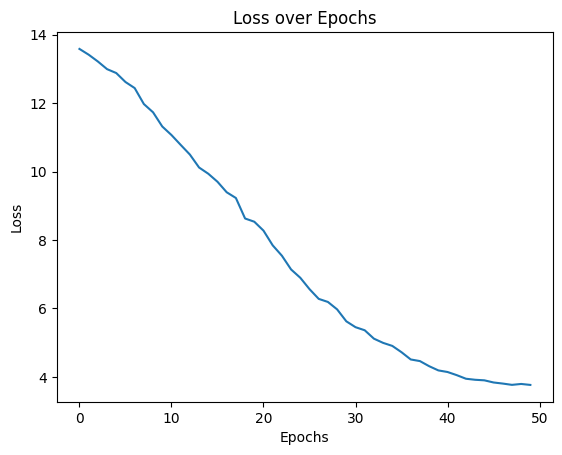

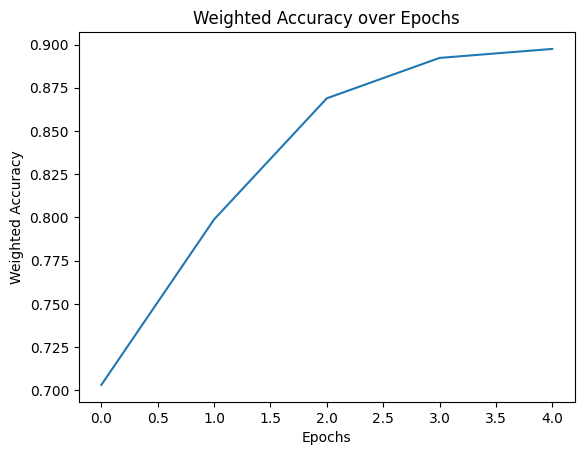

In [247]:
dataset_train = CustomDataset(x_train_seq, y_train_seq)
dataset_test = CustomDataset(x_test_seq, y_test_seq)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=True)

input_dim = x_train_seq.size(2)  # x_train_seq is of shape [samples, window, features]
model_dim = 512
num_heads = 16
num_encoder_layers = 2
output_dim = 1

model = TransformerModel(input_dim, model_dim, num_heads, num_encoder_layers, output_dim, window_size).to(device)

# binary cross entropy loss
criterion = custom_loss
lr = 1e-4 # learning rate
# I want L2 and L1 regularization with standard values
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 50 # Number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, epochs=epochs, steps_per_epoch=len(train_loader)+1)
n = 10 # Number of epochs between each validation

Score = []
Loss = np.zeros(epochs)

# Train the model
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    loss = train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epoch=epoch, device=device)
    Loss[epoch-1] = loss
    
    if(epoch % n == 0): # Valid model after last training epoch
        score = evaluate(test_loader, model, device)
        Score.append(score)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), score))
        print('-' * 80)
    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()

# Test the model on train
train_weighted_accuracy = evaluate(train_loader, model, device)
print('=' * 80)
print('| Train weighted accuracy {:5.7f}'.format(train_weighted_accuracy))
print('=' * 80)

# Test the model on test
test_weighted_accuracy = evaluate(test_loader, model, device)
print('=' * 80)
print('| Test weighted accuracy {:5.7f}'.format(test_weighted_accuracy))
print('=' * 80)
print(f"Recorded scores: {Score}")
print(f"Best score: {np.max(Score)}")
print('=' * 80)

# Plot the loss
plt.figure()
plt.plot(Loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

# Plot the scores
plt.figure()
plt.plot(Score)
plt.xlabel('Epochs')
plt.ylabel('Weighted Accuracy')
plt.title('Weighted Accuracy over Epochs')
plt.show()


In [248]:
X_test = torch.from_numpy(np.array(X_test)).float()
X_test = padding(X_test, window_size)
X_test_seq = torch.stack([X_test[i:i+window_size] for i in range(len(X_test) - window_size + 1)]).to(device)

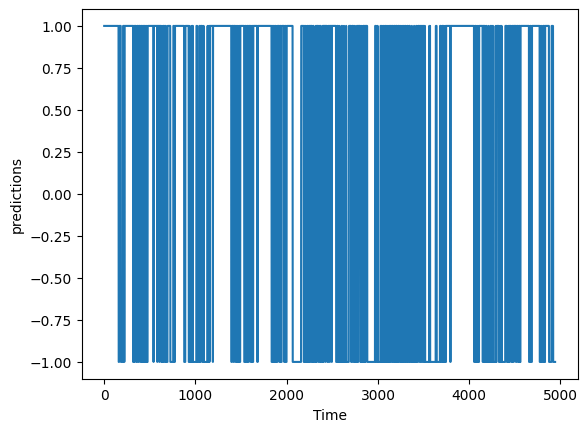

In [249]:
dataset = CustomDataset(X_test_seq, torch.zeros(X_test_seq.size(0), window_size, 1))
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

model.eval()

with torch.no_grad():
    predictions = []
    for data, _ in loader:
        data = data.to(device)
        output = model(data)
        y_pred = torch.sign(output-0.5)
        predictions.append(y_pred.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)

prediction = pd.DataFrame(columns=["DELIVERY_START", "spot_id_delta"])
prediction["DELIVERY_START"] = delivery_start
prediction["spot_id_delta"] = predictions

# Save the predictions to a CSV file
prediction.to_csv('submission.csv', index=False)

# Plot the predictions
plt.figure()
plt.plot(prediction["spot_id_delta"])
plt.xlabel('Time')
plt.ylabel('predictions')
plt.show()

